In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2
print('TF version:', tf.__version__ , '\nGPU available:', tf.config.list_physical_devices('GPU'))

TF version: 2.2.0 
GPU available: []


# Read Data
- all datasets are datetime sorted

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '../' # Paperspace

## Amazon Fashion 

In [3]:
data_path = 'datasets/' # Paperspace
# data_path = 'Data/Amazon/'
file_name = 'Amazon_01_users'
# file_name = 'am_like_ml_01'

## MovieLens 

In [4]:
# data_path = 'datasets/' # Paperspace
file_name = 'ml_1m'
data_path = 'Data/ML/'
# file_name = 'ML_05_users'
# file_name = 'ML_01_users'

In [5]:
df = pd.read_pickle(path + data_path + file_name)
# df['item_id'] = df.item.astype('category').cat.codes
# df['user_id'] = df.user.astype('category').cat.codes

df.head()

,rating,datetime,user_id,item_id
0,4,2000-12-31 22:00:19,0,2969
1,4,2000-12-31 22:00:55,0,1574
2,5,2000-12-31 22:00:55,0,957
3,5,2000-12-31 22:00:55,0,1178
4,3,2000-12-31 22:01:43,0,2147


---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks
- paper: https://arxiv.org/pdf/1608.07400.pdf
- code: https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Init

In [ ]:
res_ext = file_name[:2]
all_models = pd.read_pickle(path + 'results/' + res_ext + '/all_models')

In [77]:
res_ext = file_name[:2]
new_model_id = str(0) + '_' + res_ext
print('new model id:', new_model_id)

new model id: 0_ml


In [78]:
params = {
'model_id':new_model_id,
'train_time':0,
'epochs':2,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': '../ckpts/ckpts' + '_' + new_model_id,

'test_users': 500,
'val_users': 500,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [83]:
from CFRNN import CFRNN
total_users = df.user_id.nunique()
total_items = df.item_id.nunique()
cfrnn = CFRNN(total_users, total_items, params)

## Create Train Test Split

In [85]:
train_set, test_set = cfrnn.data_split(df)
train_set, val_set = cfrnn.data_split(train_set, val=True)

100% |########################################################################|
100% |########################################################################|


In [86]:
train_dataset = model.create_seq_batch_tf_dataset(train_set, stats=False)
val_dataset = model.create_seq_batch_tf_dataset(val_set, stats=False)

In [87]:
# train_set.to_pickle(path + 'Data/ML/train_set_cfrnn')
# test_set.to_pickle(path + 'Data/ML/test_set_cfrnn')
# val_set.to_pickle(path + 'Data/ML/val_set_cfrnn')

## Build Model

In [89]:
cfrnn.build_model()
cfrnn.compile_model(train_set=train_set)

Model: "0_ml"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (32, None, 100)           370700    
_________________________________________________________________
masking_7 (Masking)          (32, None, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (32, None, 20)            9680      
_________________________________________________________________
dense_7 (Dense)              (32, None, 3706)          77826     
Total params: 458,206
Trainable params: 458,206
Non-trainable params: 0
_________________________________________________________________
None
Creating Diveristy Bias
Compiled LSTM


---
# Train Model

In [92]:
print('#Batches:', tf.data.experimental.cardinality(train_dataset).numpy())
print('Batch size:', BATCH_SIZE)

#Batches: 188
Batch size: 32


In [90]:
cfrnn.train(train_dataset, val_dataset, verbose=1)

Fitting LSTM with parameters:
model_id                           0_ml
train_time                            0
epochs                                2
BATCH_SIZE                           32
learning_rate                       0.1
delta                              0.01
max_seq_len                          30
embedding_dim                       100
rnn_units                            20
ckpt_dir            ../ckpts/ckpts_0_ml
test_users                          500
val_users                           500
pad_value                          3706
shift_targets_by                      1
Name: 0, dtype: object
Epoch 1/2
188/188 [==============================] - 16s 84ms/step - loss: 7.5998 - recall: 0.0000e+00 - val_loss: 6.6681 - val_recall: 0.0000e+00
Epoch 2/2
188/188 [==============================] - 17s 89ms/step - loss: 7.5415 - recall: 0.0010 - val_loss: 6.5959 - val_recall: 0.0069


## Plot Training Loss, Metrics

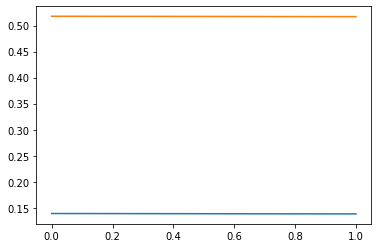

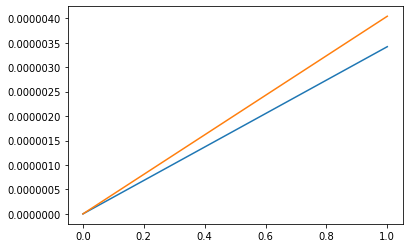

In [23]:
results = history.history
plt.plot(results['loss'])
plt.plot(results['val_loss'])
plt.show()
plt.plot(results['recall'])
plt.plot(results['val_recall'])
plt.show()

---
## Continue training from checkpoint

### Load Weights

In [20]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items,
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = BATCH_SIZE)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()

### Compile

In [21]:
from Evaluation import recall_metric, diversity_bias_loss, create_diversity_bias
diversity_bias = create_diversity_bias(train_set, total_items, delta)

optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate)
loss=diversity_bias_loss(db=diversity_bias, total_items=total_items)
metrics=[recall_metric(total_items=total_items)]

model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=metrics)

In [22]:
params

{'model_id': '0_Am',
 'train_time': 0,
 'epochs': 0,
 'BATCH_SIZE': 32,
 'learning_rate': 0.1,
 'delta': 0.6,
 'max_seq_len': 30,
 'val_perc': 0.1,
 'test_perc': 0.1,
 'n_items_val': 0,
 'n_items_test': 1,
 'pad_value': 247465,
 'shift_targets_by': 1}

In [23]:
initial_epoch = 55
total_epochs = 100

### Continue Training

In [24]:
history = model.fit(x = train_dataset, 
                    validation_data=val_dataset, 
                    epochs=total_epochs, 
                    callbacks=callbacks, 
                    initial_epoch=initial_epoch)

Epoch 56/100
3034/3034 [==============================] - 747s 246ms/step - loss: 0.0869 - recall: 0.0077 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 57/100
3034/3034 [==============================] - 720s 237ms/step - loss: 0.0869 - recall: 0.0077 - val_loss: 0.4985 - val_recall: 0.0077
Epoch 58/100
3034/3034 [==============================] - 713s 235ms/step - loss: 0.0868 - recall: 0.0077 - val_loss: 0.4985 - val_recall: 0.0077
Epoch 59/100
3034/3034 [==============================] - 714s 235ms/step - loss: 0.0867 - recall: 0.0077 - val_loss: 0.4985 - val_recall: 0.0077
Epoch 60/100
3034/3034 [==============================] - 715s 236ms/step - loss: 0.0867 - recall: 0.0078 - val_loss: 0.4986 - val_recall: 0.0078
Epoch 61/100
3034/3034 [==============================] - 714s 235ms/step - loss: 0.0866 - recall: 0.0078 - val_loss: 0.4987 - val_recall: 0.0078
Epoch 62/100
3034/3034 [==============================] - 714s 235ms/step - loss: 0.0866 - recall: 0.0078 - val_loss

---
# Predict Sequences

## Restore Latest Checkpoints

In [21]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items, 
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = None,
                         return_sequences=False)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()

model.build(tf.TensorShape([1, None]))

print('Latest checkpoint from:', tf.train.latest_checkpoint(checkpoint_dir))

Latest checkpoint from: ../ckpts/ckpts_0_Am/ckpt


## Predict

In [22]:
rank_at = 20

In [25]:
8192/2/2

2048.0

In [24]:
%%time
from Evaluation import get_predictions
preds_df = get_predictions(model=model, 
                           data=test_set, 
                           left_out=test_left_out_items, 
                           batch_size=2048, 
                           max_seq_len=max_seq_len, 
                           pad_value=pad_value, 
                           rank_at=rank_at)
preds_df

CPU times: user 5min 49s, sys: 8min 9s, total: 13min 58s
Wall time: 12min 2s


,user,pred_items_ranked,true_id
0,0,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[194041]
1,24,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[214214]
2,33,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[96786]
3,38,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[17902]
4,50,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[235218]
...,...,...,...
12132,121296,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[1292]
12133,121308,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[112187]
12134,121316,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[33094]
12135,121350,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[233491]


In [40]:
len(test_left_out_items)

12137

### Load Predictions

In [ ]:
# predictions = pd.read_pickle('CFRNN_res_200_ML_01_users')

---
# Evaluate

In [44]:
from Evaluation import get_metrics

In [45]:
steps = 5

In [46]:
metrics_test = get_metrics(preds_df, steps, rank_at)
metrics_test

Obtaining metrics time: 0.36


,rank_at,hitcounts,recall,precision
0,1,1,0.002,0.002000
1,5,1,0.002,0.000400
2,10,1,0.002,0.000200
3,15,1,0.002,0.000133
4,20,1,0.002,0.000100


---
# Store Results

In [ ]:
from Models import store_LSTM_model
# store_path = path + 'results/CFRNN/' + res_ext + '/all_models'
store_path = path + 'results/' + res_ext + '/all_models'
train_time = np.sum(timing_callback.logs)
all_models = store_LSTM_model(store_path, params.copy(), history.history.copy(), train_time, metrics_test, store=True)

In [ ]:
all_models

### Val Set Metrics ML

In [36]:
metrics_val_set_vsl = get_metrics(preds_val, 5, 20)
metrics_val_set_vsl

Obtaining metrics time: 1.12


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,8,0.004808,0.000962
2,10,15,0.009014,0.000901
3,15,21,0.012620,0.000841
4,20,27,0.016226,0.000811


# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)

In [ ]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 

In [ ]:
# max_seq_len = 30
# min_seq_len = 10
# shift_targets_by = 1

# from Data_prep import get_x_y_sequences, min_padding
# vsl = True # Set for training later

# # Train Set
# user_sequences_x, user_sequences_y, user_order = get_x_y_sequences(train_set, shift_targets_by)
# padded_sequences_x = min_padding(user_sequences_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_y = min_padding(user_sequences_y, BATCH_SIZE, min_seq_len, max_seq_len)

# # Val Set 
# user_sequences_val_x, user_sequences_val_y, user_order = get_x_y_sequences(val_set, shift_targets_by, stats=False)
# padded_sequences_val_x = min_padding(user_sequences_val_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_val_y = min_padding(user_sequences_val_y, BATCH_SIZE, min_seq_len, max_seq_len)

In [ ]:
# test_set_u_i = test_set.groupby('user_id')['item_id'].apply(list)
# test_X = []
# test_y = []
# all_predictions = []
# for user_items in test_set_u_i:
#     test_X.append(user_items[-200:-1])
#     test_y.append(user_items[-1:])

# for i, seq in enumerate(test_X): 
#     seq = seq.copy()
#     predictions = []
#     for i in range(20):
#         pred_item_id = model.predict_classes(np.array([seq,]), batch_size=1)[0]
#         seq.append(pred_item_id)
#         predictions.append(pred_item_id)
#     all_predictions.append(predictions)
    
# predictions_df = pd.DataFrame(list(zip(test_set.user_id.unique(), all_predictions, test_y)),
#                               columns=['user', 'pred_items_ranked', 'true_id'])